# PyTorch
# Intro to Neural Networks
Lets use some simple models and try to match some simple problems

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision.utils as vutils
import torchvision.models as models
from tensorboardX import SummaryWriter

import matplotlib.pyplot as plt

### Data Loading

Before we dive deep into the nerual net, lets take a brief aside to discuss data loading.

Pytorch provides a Dataset class which is fairly easy to inherit from.  We need only implement two methods for our data load:
9. __len__(self) -> return the size of our dataset
9. __getitem__(self, idx) -> return a data at a given index.

The *real* benefit of implimenting a Dataset class comes from using the DataLoader class.
For data sets which are too large to fit into memory (or more likely, GPU memory), the DataLoader class gives us two advantages:
9. Efficient shuffling and random sampling for batches
9. Data is loaded in a seperate *processes*.

Number (2) above is *important*.  The Python interpretter is single threaded only, enforced with a GIL (Global Interpreter Lock).  Without (2), we waste valuable (and potentially expensive) processing time shuffling and sampling and building tensors.  
So lets invest a little time to build a Dataset and use the DataLoader.

In or example below, we are going to mock a dataset with a simple function, this time:

y = sin(x) + 0.01 * x^2

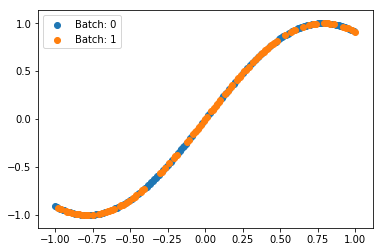

In [2]:
#impliment the dataset
class FunctionalDataset(Dataset):
    def __init__(self, fun=None):
        super(FunctionalDataset, self).__init__()
        if fun:
            self.fun = fun
        else:
            self.fun = lambda x: np.sin(2. * x)
        
    def __len__(self):
        return 201
    
    def __getitem__(self, idx):
        x = 0.01 * idx - 1.0
        return np.float32(x), np.float32(self.fun(x))

#create a data loader with a subprocess for feeding data
dataset = FunctionalDataset()
dataloader = DataLoader(dataset, batch_size=101, shuffle=True, num_workers=1)

#lets sample a few batches and plot the results to see our function
for i, (X, Y) in enumerate(dataloader):
    plt.scatter(X,Y, label='Batch: {}'.format(i))
plt.legend()    
plt.show()

### Our First Neural Net
Lets now build our first neural net.

In this case, we'll take a classic approach with 2 fully connected hidden layers and a fully connected output layer.

In [3]:
class FirstNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FirstNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = x.view(-1,1)
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out
    
net = FirstNet(input_size=1, hidden_size=64, num_classes=1)

print(net)

FirstNet(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)


Lets look at a few key features of our net:

1) We have 3 fully connected layers, defined in our init function.

2) We define a *forward pass* method which is the prediction of the neural net given an input X

3) Note that we make a *view* of our input array.  In our simple model, we expect a 1D X value, and we output a 1D Y value.  For efficiency, we may wish to pass in *many* X values, particularly when training.  Thus, we need to set up a *view* of our input array: Many 1D X values.  -1 in this case indicates that the first dimension (number of X values) is inferred from the tensor's shape.

### Logging and Visualizing to TensorboardX

Lets track the progress of our training and visualize in tensorboard (using tensorboardX).  We'll also add a few other useful functions to help visualize things.

To view the output, run:
`tensorboard --logdir nb/run`

In [4]:
tbwriter = SummaryWriter()

### Graph Visualization and Batching
We will begin by adding a graph visualization to tensorboard.  To do this, we need a valid input to our network.

Our network is simple - floating point in, floating point out.  *However*, pytorch expects us to *batch* our inputs - therefore it expects an *array* of inputs instead of a single input.  There are many ways to work around this, I like "unsqueeze".

In [5]:
X = Variable(torch.FloatTensor([0.0]))
tbwriter.add_graph(net, X)

### Cuda
IF you have a GPU available, your training will run much faster.
Moving data back and forth between the CPU and the GPU is fairly straightforward - although it can be easy to forget.

In [6]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    net = net.cuda()

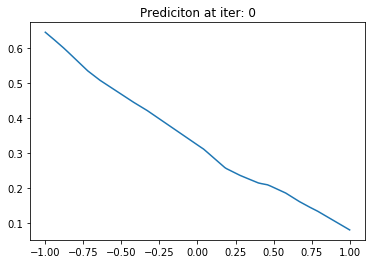

In [7]:
def makeFig(iteration):
    X = np.linspace(-1, 1, 201, dtype=np.float32)
    X = torch.FloatTensor(X)
    X = Variable(X)
    if use_cuda:
        Y = net.forward(X.cuda()).cpu()
    else:
        Y = net.forward(X)
    
    fig = plt.figure()
    plt.plot(X.data.numpy(), Y.data.numpy())
    plt.title('Prediciton at iter: {}'.format(iteration))
    return fig
    
def showFig(iteration):
    fig = makeFig(iteration)
    plt.show()
    plt.close()
    
def logFig(iteration):
    fig = makeFig(iteration)
    fig.canvas.draw()
    raw = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    raw = raw.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    tbwriter.add_image('Prediction at iter: {}'.format(iteration), raw)
    plt.close()
    
showFig(0)

Ok, we have a ways to go.  Lets use our data loader and do some training.  Here we will use MSE loss (mean squared error) and SGD optimizer.

In [8]:
%%time

learning_rate = 0.1
num_epochs = 2000

if use_cuda:
    net = net.cuda()

data_iter = iter(dataloader)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
net.train()

for epoch in range(num_epochs):
    for X, Y in dataloader:
        if use_cuda:
            X = Variable(X).cuda()
            Y = Variable(Y).cuda()
        else:
            X = Variable(X)
            Y = Variable(Y)
        pred = net.forward(X)
        loss = criterion(pred, Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tbwriter.add_scalar("Loss", loss.data[0])

    if (epoch % 100 == 99):
        print("Epoch: {:>4} Loss: {}".format(epoch, loss.data[0]))
        for name, param in net.named_parameters():
            tbwriter.add_histogram(name, param.clone().cpu().data.numpy(), epoch)
        logFig(epoch)
        
net.eval()

Epoch:   99 Loss: 0.004570935852825642


/home/gram/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Epoch:  199 Loss: 0.0018615875160321593
Epoch:  299 Loss: 0.001203774707391858
Epoch:  399 Loss: 0.0008993052178993821
Epoch:  499 Loss: 0.0006963883060961962
Epoch:  599 Loss: 0.0005946041783317924
Epoch:  699 Loss: 0.0006583805661648512
Epoch:  799 Loss: 0.0003274207701906562
Epoch:  899 Loss: 0.00038939504884183407
Epoch:  999 Loss: 0.00021736641065217555
Epoch: 1099 Loss: 0.00028503689100034535
Epoch: 1199 Loss: 0.00022985295800026506
Epoch: 1299 Loss: 0.00018812151392921805
Epoch: 1399 Loss: 0.00013008975656703115
Epoch: 1499 Loss: 0.00018550149980001152
Epoch: 1599 Loss: 0.00015687722770962864
Epoch: 1699 Loss: 9.718279034132138e-05
Epoch: 1799 Loss: 9.07975627342239e-05
Epoch: 1899 Loss: 0.00010480544733582065
Epoch: 1999 Loss: 9.567214146954939e-05
CPU times: user 18.1 s, sys: 7.28 s, total: 25.4 s
Wall time: 21.6 s


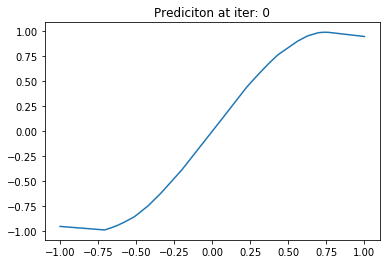

In [9]:
showFig(0)

## Conclusions

We've written our first network, take a moment and play with some of our models here.

Try inputting a different function into the functional dataset, such as:
  dataset = FunctionalDataset(lambda x: 1.0 if x > 0 else -1.0

Try experimenting with the network - change the number of neurons in the layer, or add more layers.
  
Try changing the learning rate (and probably the number of epochs).

And lastly, try disabling cuda (if you have a gpu).

#### How well does the prediction match our input function?
#### How long does it take to train?

One last note: we are absolutely *over-fitting* our dataset here.  In this example, that's ok.  For real work, we will need to be more careful.

Speaking of real work, lets do some real work identifying customer cohorts.